In [3]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

In [4]:
#config of GPT model

GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 2024,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate':0.1,
    'qkv_bias':False
}

In [5]:
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()

    def forward(self, x):
        return x
    

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim =0)  # without this batch would be a list
print(batch)
print(batch.shape)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
torch.Size([2, 4])


In [7]:
torch.manual_seed(234)

model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits.shape)
print(logits)

torch.Size([2, 4, 50257])
tensor([[[ 1.6791, -0.8027,  0.3189,  ...,  1.8888,  0.6621, -1.8136],
         [-0.0911, -0.6094,  0.4110,  ..., -2.1991,  1.1511,  1.1496],
         [ 0.2629, -0.2988, -0.1211,  ...,  1.1622, -0.0957,  1.5308],
         [-0.2641, -0.1038,  1.2224,  ..., -0.3719,  0.4259, -0.3438]],

        [[ 1.1508, -0.5651,  0.2684,  ...,  1.6037,  1.0519, -1.2464],
         [ 1.0766,  0.6448,  1.4516,  ..., -0.5441,  0.8478, -0.6536],
         [-0.7666, -1.0093,  1.4833,  ..., -0.6308, -0.8692,  0.9653],
         [ 0.9074,  0.5456,  0.8014,  ...,  0.0505,  0.7121,  0.0241]]],
       grad_fn=<UnsafeViewBackward0>)


In [8]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
mean = out.mean(dim=-1, keepdim= True)
var = out.var(dim=-1, keepdim=True)

print(mean,'\n' ,var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>) 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [10]:
out_norm = (out-mean)/torch.sqrt(var)
print(out_norm)

mean = out_norm.mean(dim=-1, keepdim= True)
var = out_norm.var(dim=-1, keepdim= True)

print(mean,'\n',var)

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>) 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
# defining a layer normalization class
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        norm_x = (x-mean)/torch.sqrt(var+self.eps)
        return self.scale * norm_x + self.shift

In [12]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, keepdim = True, unbiased = False)
print(mean)
print(var)


tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
                                        ))

    

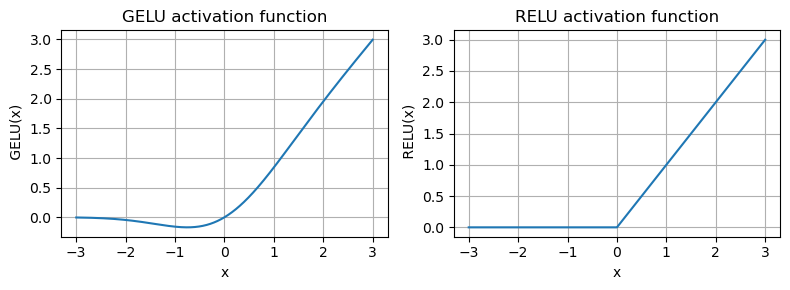

In [14]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 1000)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize = (8,3))
for i, (y, label) in enumerate (zip([y_gelu, y_relu], ['GELU', 'RELU']), 1):
    plt.subplot(1,2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel('x')
    plt.ylabel(f" {label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# feed forward NN

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)

In [16]:
# skip connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
            ]
        )
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [17]:
layer_sizes = [3 , 3 , 3, 3, 3 , 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(124)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut = False)


In [18]:
def print_gradient(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')


In [37]:
print_gradient(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 9.26417633309029e-05
layers.1.0.weight has gradient mean of 0.0001513055758550763
layers.2.0.weight has gradient mean of 0.0013726619072258472
layers.3.0.weight has gradient mean of 0.013747615739703178
layers.4.0.weight has gradient mean of 0.08553162217140198


In [19]:
# with skip connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut= True)
print_gradient(model_with_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [24]:
from previous_chapters import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias'])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        # attn block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # skip connection (adding the orginial input)
        
        # FF block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x
    


In [25]:
# instantiate a transformer block

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print(x.shape)
print(output.shape)

torch.Size([2, 4, 768])
torch.Size([2, 4, 768])


In [26]:
# Dummy to actual GPT Model

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    

In [27]:
# initalize the GPT model using GPT_CONFIG

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print(batch)
print(out.shape)
print(out)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
torch.Size([2, 4, 50257])
tensor([[[ 0.4534,  0.3608, -0.3297,  ..., -0.2444,  0.8121,  0.2925],
         [ 0.4109,  0.6306,  0.2573,  ..., -0.1532,  0.5570,  1.1812],
         [ 0.0856, -0.1053,  0.6733,  ...,  0.7824,  0.1432,  0.1869],
         [ 0.5747,  0.7695,  0.4323,  ..., -1.3219,  0.3381, -0.3308]],

        [[ 0.4255,  0.5877, -0.2912,  ..., -0.2886,  0.1824,  0.1292],
         [ 0.6317,  0.8366,  0.1083,  ..., -0.2446,  0.5990, -0.0172],
         [ 0.0547,  0.2446,  0.3359,  ..., -0.2778,  0.6132, -0.3943],
         [ 1.2783, -0.0901,  0.1120,  ..., -1.4741,  0.8779,  0.3975]]],
       grad_fn=<UnsafeViewBackward0>)


In [28]:
total_params = sum(p.numel() for p in model.parameters())  #numel = number of elements
print(total_params)

163777536


In [39]:
# why 163M parameters when we initalized  124M parameter?
print('Token embedding layer shape', model.tok_emb.weight.shape)
print('Output layer shape', model.out_head.weight.shape)

Token embedding layer shape torch.Size([50257, 768])
Output layer shape torch.Size([50257, 768])


### Weight Tying
Weight tying is a technique where we reuse (or "tie") the same weight parameters for multiple parts of a model instead of learning separate weights for each.

self.out_head.weight = self.tok_emb.weight → Assigns the same weight matrix to both layers.
This means during training, both layers update the same weights, rather than maintaining separate ones.

In [38]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())

print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}" )

Number of trainable parameters considering weight tying: 125,180,160


In [45]:
# parameters in transformer blocks


block = TransformerBlock(GPT_CONFIG_124M)
print(block)

TransformerBlock(
  (att): MultiHeadAttention(
    (W_query): Linear(in_features=768, out_features=768, bias=False)
    (W_key): Linear(in_features=768, out_features=768, bias=False)
    (W_value): Linear(in_features=768, out_features=768, bias=False)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ff): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (drop_shortcut): Dropout(p=0.1, inplace=False)
)


In [43]:
total_params_ff = sum(p.numel() for p in block.ff.parameters())
print(total_params_ff)

4722432


In [44]:
total_params_att = sum(p.numel() for p in block.att.parameters())
print(total_params_att)

2360064


In [48]:
# memory requirements

total_size_bytes = total_params * 4  # 4 bytes per param assuming float32
total_size_mb = total_size_bytes / (1024 * 1024)  # converts to megabytes
print(f"total size of the model: {total_size_mb: .2f} MB")

total size of the model:  624.76 MB


### Converting Outputs to text

In [49]:
# generate text

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[: , -1, :]
        probas = torch.softmax(logits, dim = -1)
        idx_next = torch.argmax(probas, dim = -1, keepdim = True)
        idx = torch.cat((idx, idx_next), dim = 1)

    return idx

In [50]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(encoded_tensor.shape)

[15496, 11, 314, 716]
torch.Size([1, 4])


In [52]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M['context_length']
)

print(out)

print('length',len(out[0]))

tensor([[15496,    11,   314,   716, 48281, 36387, 43686, 12233, 13618,  6229]])
length 10


In [53]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am clutchingintestinal 344 delete Reached ment
